『統計的テキストモデル』持橋大地著, 岩波書店 (2025)
## 3章 単語の統計モデル



注意: スクリプトは、すべて中身を読んでから使うようにして下さい。

In [1]:
# 必要なライブラリの準備
import os
import sys
!pip install gensim
!pip install japanize_matplotlib
import gensim
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# スクリプトとデータの準備
# コーパスが大きいため、800MB程度ありますので注意して下さい。
!curl -O http://chasen.org/~daiti-m/textmodel/word/word.tar.gz
!tar xvfz word.tar.gz
![ ! -d model ] && mkdir model

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  825M  100  825M    0     0  9873k      0  0:01:25  0:01:25 --:--:-- 10.5M
bin/
bin/mknlm.py
bin/freq.py
bin/entmax-plot.py
bin/vcovariance.py
bin/visualize-ja.py
bin/dirichlet.py
bin/word2vec-weights.py
bin/whiten-plot.py
bin/similarities.py
bin/plot-alpha.py
bin/phraser.py
bin/knlm.gen.py
bin/dirichlet-large.py
bin/zcenter.py
bin/visualize3-ja.py
bin/similars.py
bin/freq-sort.py
bin/util.py
bin/rutil.py
bin/vcenter.py
bin/mkntest.py
bin/collocation.py
bin/word2vec.py
bin/absolute.py
bin/whead.py
bin/hdl.gen.py
bin/absolute-stat.py
bin/bigram.py
bin/putil.py
bin/visualize.py
bin/plot-vocabulary.py
bin/polya-counts.py
bin/vwhiten.py
bin/pca2D.py
bin/eprint.py
bin/glove
bin/whiten.py
bin/common.py
bin/polya.py
bin/pmivector.py
bin/opts.py
bin/collocate.py
bin/progress-vocabulary.py
bin/mknlm.test.py
bin/readword.py
bin/knlm.py


In [3]:
sys.path.append (os.getcwd() + '/bin')
%env PATH={os.getcwd()+'/bin'}:{os.environ['PATH']}
%matplotlib inline

env: PATH=/content/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


3.1 文字から単語へ

In [4]:
# MeCabのインストール
!pip install mecab-python3
!pip install unidic-lite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658817 sha256=0cfd69a980c11e60c78250e444ed94bd86a91cceb28dd9a3e75fe7ca07d0281d
  Stored in directory: /root/.cache/pip/wheels/b7/fd/e9/ea4459b868e6d2902e8d80e82dbacb6203e05b3b3a58c64966
Successfully built unidic-lite


In [5]:
import MeCab
tagger = MeCab.Tagger ("-Owakati")
s = "これは日本語の文字列です。"
tagger.parse(s).split()

['これ', 'は', '日本', '語', 'の', '文字', '列', 'です', '。']

In [6]:
with open('data/ginga.txt', 'r') as fh:
    for line in fh:
        buf = line.rstrip('\n')
        if len(buf) > 0:
            words = tagger.parse(buf).split()
            print (words)

['銀河', '鉄道', 'の', '夜']
['一', '、', '午后', 'の', '授業']
['「', 'で', 'は', 'みな', 'さん', 'は', '、', 'そう', 'いう', 'ふう', 'に', '川', 'だ', 'と', '云わ', 'れ', 'たり', '、', '乳', 'の', '流れ', 'た', 'あと', 'だ', 'と', '云わ', 'れ', 'たり', 'し', 'て', 'い', 'た', 'この', 'ぼんやり', 'と', '白い', 'もの', 'が', 'ほんとう', 'は', '何', 'か', 'ご', '承知', 'です', 'か', '。', '」', '先生', 'は', '、', '黒板', 'に', '吊し', 'た', '大きな', '黒い', '星座', 'の', '図', 'の', '、', '上', 'から', '下', 'へ', '白く', 'けぶっ', 'た', '銀河', '帯', 'の', 'よう', 'な', 'ところ', 'を', '指し', 'ながら', '、', 'みんな', 'に', '問', 'を', 'かけ', 'まし', 'た', '。']
['カムパネルラ', 'が', '手', 'を', 'あげ', 'まし', 'た', '。', 'それ', 'から', '四五', '人', '手', 'を', 'あげ', 'まし', 'た', '。', 'ジョバンニ', 'も', '手', 'を', 'あげよう', 'と', 'し', 'て', '、', '急い', 'で', 'その', 'まま', 'やめ', 'まし', 'た', '。', 'たしか', 'に', 'あれ', 'が', 'みんな', '星', 'だ', 'と', '、', 'いつ', 'か', '雑誌', 'で', '読ん', 'だ', 'の', 'でし', 'た', 'が', '、', 'このごろ', 'は', 'ジョバンニ', 'は', 'まるで', '毎日', '教室', 'で', 'も', 'ねむく', '、', '本', 'を', '読む', 'ひま', 'も', '読む', '本', 'も', 'ない', 'の', 'で', '、', 'なん', 'だ', 'か', 'どんな', 'こと',

In [7]:
with open ('data/ginga.words.txt', 'w') as oh:
    with open ('data/ginga.txt', 'r') as fh:
        for line in fh:
            buf = line.rstrip('\n')
            if len(buf) > 0:
                words = tagger.parse(buf).split()
                oh.write (' '.join(words) + '\n')

In [8]:
# 教師なし形態素解析の学習データ (例, ラテン語の場合)
!head -8 data/aeneis.txt

armavirumquecanotroiaequiprimusaboris
italiamfatoprofuguslaviniaquevenit
litoramultumilleetterrisiactatusetalto
visuperumsaevaememoremiunonisobiram
multaquoqueetbellopassusdumcondereturbem
inferretquedeoslatiogenusundelatinum
albaniquepatresatquealtaemoeniaromae
musamihicausasmemoraquonuminelaeso


In [9]:
# 教師なし形態素解析の学習結果 (例, 一部)。辞書は一切使っていません。
!head -8 data/aeneis.seg

arma virum que cano troia equi primus aboris
italiam fato profugus lavinia quevenit
litora multum ille et terris iactatus etalto
vi superum saeva e memorem iunonis obiram
multa quoque et bello passus dum conderet urbem
inferret que deos latio genusunde latinum
albani quepatres atque altae moenia romae
musa mihi causas memora quo num inelaeso


3.2 単語の統計と冪乗則

In [10]:
from collections import defaultdict
freq = defaultdict (int)
with open ('data/ginga.words.txt', 'r') as fh:
    for line in fh:
        words = line.rstrip('\n').split()
        for word in words:
            freq[word] += 1
for w,c in freq.items():
    print ('%s -> %d' % (w,c))

銀河 -> 25
鉄道 -> 5
の -> 1299
夜 -> 6
一 -> 60
、 -> 988
午后 -> 2
授業 -> 2
「 -> 293
で -> 266
は -> 631
みな -> 7
さん -> 67
そう -> 75
いう -> 44
ふう -> 3
に -> 819
川 -> 31
だ -> 190
と -> 380
云わ -> 4
れ -> 42
たり -> 54
乳 -> 5
流れ -> 17
た -> 956
あと -> 9
し -> 217
て -> 926
い -> 141
この -> 37
ぼんやり -> 28
白い -> 27
もの -> 29
が -> 527
ほんとう -> 45
何 -> 59
か -> 214
ご -> 2
承知 -> 1
です -> 164
。 -> 1120
」 -> 292
先生 -> 11
黒板 -> 1
吊し -> 1
大きな -> 32
黒い -> 28
星座 -> 4
図 -> 4
上 -> 26
から -> 179
下 -> 21
へ -> 125
白く -> 12
けぶっ -> 1
帯 -> 3
よう -> 208
な -> 174
ところ -> 21
を -> 569
指し -> 6
ながら -> 70
みんな -> 54
問 -> 1
かけ -> 12
まし -> 461
カムパネルラ -> 101
手 -> 20
あげ -> 11
それ -> 78
四五 -> 1
人 -> 63
ジョバンニ -> 189
も -> 345
あげよう -> 3
急い -> 6
その -> 164
まま -> 10
やめ -> 1
たしか -> 5
あれ -> 11
星 -> 21
いつ -> 18
雑誌 -> 3
読ん -> 3
でし -> 112
このごろ -> 2
まるで -> 37
毎日 -> 2
教室 -> 4
ねむく -> 1
本 -> 17
読む -> 3
ひま -> 1
ない -> 107
なん -> 15
どんな -> 7
こと -> 39
よく -> 15
わから -> 9
気持ち -> 3
する -> 51
早く -> 9
見 -> 85
附け -> 1
あなた -> 14
わかっ -> 4
いる -> 106
でしょう -> 19
勢 -> 6
立ちあがり -> 4
立っ ->

3.2.1 Heapsの法則

In [11]:
# テキスト中の位置(単語単位)と、そこまでの語彙の大きさを表示
!progress-vocabulary.py data/alice.txt

1000	367
2000	587
3000	766
4000	906
5000	1062
6000	1192
7000	1299
8000	1409
9000	1501
10000	1596
11000	1693
12000	1804
13000	1875
14000	1939
15000	2009
16000	2086
17000	2166
18000	2217
19000	2285
20000	2330
21000	2417
22000	2464
23000	2543
24000	2597
25000	2650
26000	2696
26396	2748


In [12]:
# 上記の情報を各コーパスについて計算し、データファイルにしておく
!progress-vocabulary.py data/alice.txt > model/alice.dat
!progress-vocabulary.py data/ginga.words.txt > model/ginga.dat
!progress-vocabulary.py data/brown.txt > model/brown.dat
!progress-vocabulary.py data/ja.text8.txt > model/ja.text8.dat

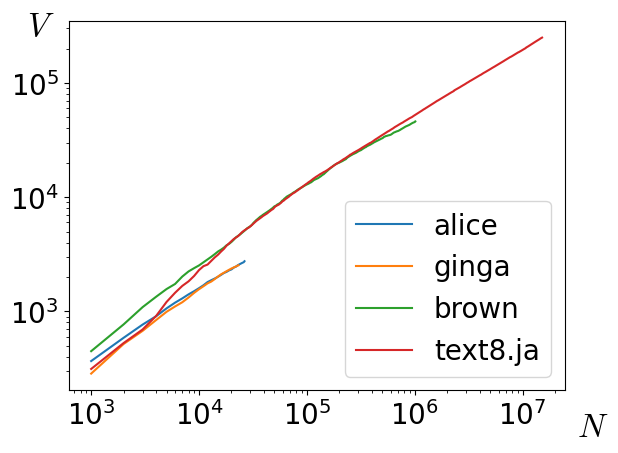

<Figure size 640x480 with 0 Axes>

In [13]:
# 両対数軸でプロット
%run bin/plot-vocabulary.py model/alice.dat model/ginga.dat model/brown.dat model/ja.text8.dat

3.2.2 Zipfの法則

In [14]:
for (w,c) in sorted (freq.items(), key=lambda x: x[1], reverse=True):
    print ('%s -> %d' % (w,c))

の -> 1299
。 -> 1120
、 -> 988
た -> 956
て -> 926
に -> 819
は -> 631
を -> 569
が -> 527
まし -> 461
と -> 380
も -> 345
「 -> 293
」 -> 292
で -> 266
し -> 217
か -> 214
よう -> 208
だ -> 190
ジョバンニ -> 189
から -> 179
な -> 174
です -> 164
その -> 164
い -> 141
ん -> 135
へ -> 125
でし -> 112
ない -> 107
いる -> 106
もう -> 103
カムパネルラ -> 101
お -> 97
見 -> 85
よ -> 81
それ -> 78
そう -> 75
なっ -> 75
云い -> 74
や -> 73
ながら -> 70
方 -> 70
さん -> 67
人 -> 63
一 -> 60
何 -> 59
中 -> 57
また -> 56
たり -> 54
みんな -> 54
ぼく -> 54
たち -> 54
来 -> 53
する -> 51
つ -> 48
ます -> 47
ほんとう -> 45
けれど -> 45
いう -> 44
れ -> 42
立っ -> 42
どこ -> 42
ねえ -> 42
そして -> 41
ね -> 41
どう -> 41
見え -> 40
こと -> 39
ませ -> 39
小さな -> 39
ず -> 39
そこ -> 39
窓 -> 39
ああ -> 39
汽車 -> 39
前 -> 38
いま -> 38
あの -> 38
この -> 37
まるで -> 37
眼 -> 37
とき -> 36
行っ -> 36
って -> 35
なく -> 34
僕 -> 33
そら -> 33
大きな -> 32
ある -> 32
行く -> 32
川 -> 31
二人 -> 31
まで -> 31
だろう -> 30
もの -> 29
水 -> 29
向う -> 29
ぼんやり -> 28
黒い -> 28
たくさん -> 28
なり -> 28
たら -> 28
青年 -> 28
白い -> 27
いっぱい -> 27
さっき -> 27
あり -> 27
少し -> 27
風 -> 27
上 -

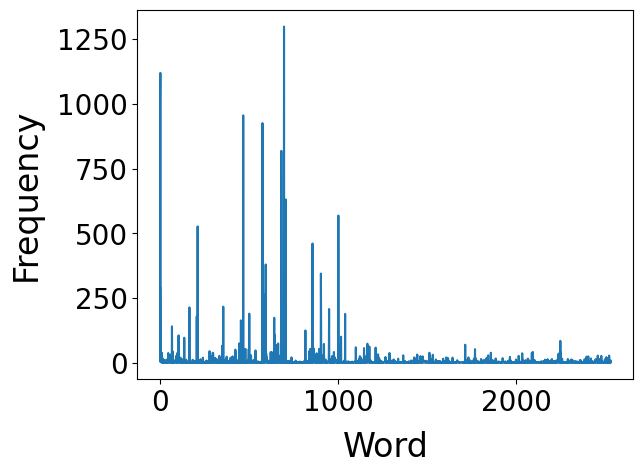

<Figure size 640x480 with 0 Axes>

In [15]:
%run bin/freq.py data/ginga.words.txt

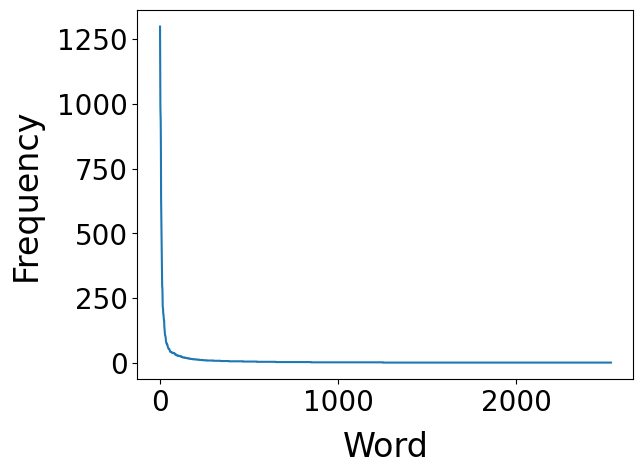

<Figure size 640x480 with 0 Axes>

In [16]:
%run bin/freq-sort.py data/ginga.words.txt

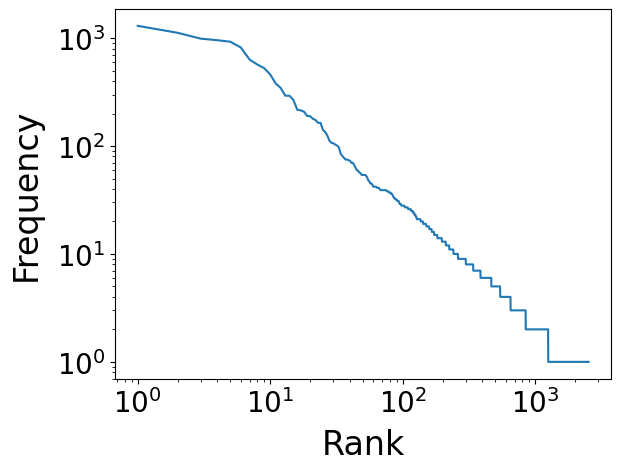

<Figure size 640x480 with 0 Axes>

In [17]:
%run bin/zipf.py data/ginga.words.txt

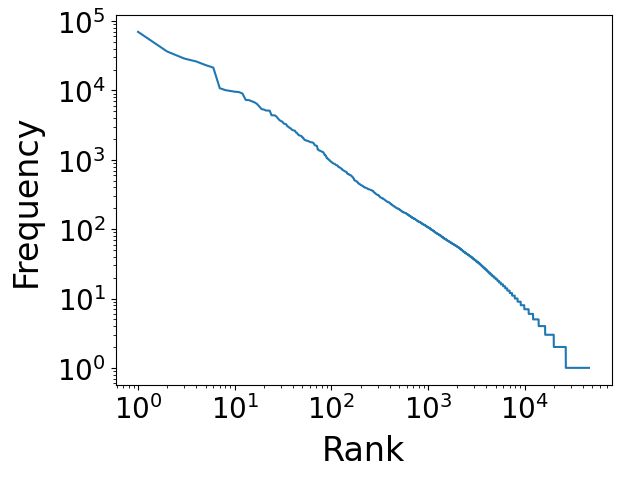

<Figure size 640x480 with 0 Axes>

In [18]:
%run bin/zipf.py data/brown.txt

3.3 単語の統計的フレーズ化

In [ ]:
# Normalized PMIによるテキストの統計的フレーズ化の計算
!phraser.py data/ja.text8.txt model/phrased.txt 4 0.5

computing phrases: threshold = 0.5 minfreq = 10
pass [1/4]..
- computing phrases.. writing output..
pass [2/4]..
- computing phrases.. writing output..
pass [3/4]..
- computing phrases.. writing output..
pass [4/4]..
- computing phrases.. writing output..
done.


In [ ]:
# phraser.pyの使い方を表示
!phraser.py

usage: % phraser.py input output passes [threshold] [minfreq]
$Id: phraser.py,v 1.1 2021/04/29 00:44:47 daichi Exp $


In [ ]:
# "_"でフレーズ化されたテキスト (最初の7行)
!head -7 model/phrased.txt

ちょん 掛け と は 、 相撲 の 決まり 手 の ひとつ で_ある_。
自分 の 右 足 の 踵 を 相手 の 右 足 の 踵 に 掛け 、 後方 に 捻っ て 倒す 技 。
手斧 を かける 仕草 に 似 て_いる こと から 、 ちょう な が 訛っ て ちょん 掛け と_なっ_た と いわ_れる 。
柔道 の 小内 刈 と ほぼ_同じ 動き を 見せる 技 で_ある_。
1944_年 1_月 場所 6_日 目 、 36 連勝 中 の 横綱 双葉_山 に 、 枩 ノ 里 が 決め 、 金星 を 挙げ て_いる_。
最近 で は 2014_年 11_月 場所 7_日 目 に 常幸 龍 が 照 ノ 富士 に 、 2012_年 5_月 場所 5 日 目 に 朝 赤 龍 が 若 の 里 に この 技 で 勝利 し_て_いる ほか 、 十_両 で は 2014_年 1_月 場所 12_日 目 に 天 鎧 鵬 が 双 大竜 に 、 2013_年 5_月 場所 2 日 目 に 鬼 嵐 が 丹 蔵 に 、 それぞれ この 技 で 勝利 し_て_いる_。
幕下 以下 で は 旭 大星 が 得意 と し て_おり 、 10 回 以上 この 技 を 決め て_いる 。甲 越 同盟 は 、 天正 7 年 に 甲斐 の 戦国_大名 武田 勝頼 と 越後 の 戦国_大名 上杉_景勝 と の 間 で 成立 し_た 同盟 。


In [ ]:
# "_" で結合されたフレーズの頻度を数え、ソートして結果ファイルに記録
!awk '{for(i=1;i<=NF;i++)if($i~/_/)freq[$i]++};END{for(w in freq)print freq[w],w}' model/phrased.txt | sort -nr > model/phrases.txt

In [ ]:
# 頻度の高いフレーズの上位25個を表示
!head -25 model/phrases.txt

58090 し_た
56603 た_。
44696 し_た_。
41165 で_ある_。
26195 で_ある
25676 て_いる_。
25604 さ_れ
25071 さ_れ_た
23443 さ_れ_た_。
22139 し_て
20754 さ_れる
18690 ある_。
17822 し_て_いる_。
14773 て_いる
12866 あっ_た
12410 さ_れ_て_いる_。
12033 て_おり
11622 あっ_た_。
11321 て_い_た
11002 て_い_た_。
10366 と_なっ_た_。
9349 し_て_いる
9225 的_な
8523 し_て_い_た
7249 行わ_れ


In [ ]:
# 1000~1020行目を表示する。sedの使い方については、2章終わりのコラムを参照のこと。
!sed -n 1000,1020p model/phrases.txt

124 筐_体
124 神_々
124 室町_幕府
124 ワシントン_州
124 ね_ば_なら
124 こう_いっ
123 補助_金
123 天文学_者
123 ヘブライ_語
123 1_月_31_日
122 直通_運転
122 生産_量
122 構成_員
122 副_社長
122 停留_場
122 位置づけ_られ
122 ファイル_システム
122 なれ_ば
121 高速_バス
121 積極_的_な
121 奇妙_な


In [ ]:
# ランダムに全体から25行を選んでから、頻度でソートして表示 [全体の様子を見るのに有効]
!shuf model/phrases.txt | head -25 | sort -nr

12866 あっ_た
208 典型_的_な
69 作業_員
47 地質_学者
43 榴弾_砲
32 公安_委員_会
28 関数_オブジェクト
28 気_相
23 奪わ_れ_て
20 胆汁_酸
18 魏_志
17 水産_業
16 ミクロネシア_連邦
15 β_鎖
14 芦_有
13 研究_科_博士_課程_単位_取得_退学
13 ホ_長調
12 テイルズ_オブ_ファンタジア
12 ofdm_シンボル
11 増_備に
11 スロープ_スタイル
10 表紙_イラスト
10 腕輪_伝説
10 擬_ポテンシャル
8 全権_大使


3.4 単語nグラム言語モデル

In [ ]:
from collections import defaultdict
def parse (file):
    EOS = "_EOS_"
    freq = {}
    with open (file, 'r') as fh:
        for line in fh:
            words = line.rstrip('\n').split()
            words.insert (0, EOS); words.append (EOS)
            T = len(words)
            for t in range(T-1):
                w = words[t]
                v = words[t+1]
                if not (w in freq):
                    freq[w] = defaultdict(int)
                freq[w][v] += 1
    return freq

In [ ]:
freq = parse ('data/ginga.words.txt')
freq

{'_EOS_': defaultdict(int,
             {'銀河': 1,
              '一': 1,
              '「': 288,
              'カムパネルラ': 5,
              'ところ': 4,
              'ジョバンニ': 42,
              'やっぱり': 1,
              '先生': 4,
              'そして': 9,
              '二': 1,
              'けれど': 2,
              '家': 1,
              '六': 2,
              '三': 1,
              '四': 1,
              '坂': 1,
              '（': 5,
              'と': 2,
              'それ': 6,
              '空気': 1,
              'その': 9,
              '十字': 1,
              '五': 1,
              '牧場': 1,
              '町': 1,
              'そこ': 2,
              'ああ': 2,
              'する': 1,
              '気': 1,
              'すぐ': 1,
              'そっち': 1,
              'ごとごと': 2,
              '線路': 1,
              '七': 1,
              'いきなり': 1,
              '俄か': 1,
              '向う岸': 1,
              '早く': 1,
              'さわやか': 1,
              '〔': 2,
              '二人': 6,
              'さき': 1,

In [ ]:
freq["銀河"]["ステーション"]

5

In [ ]:
freq["銀河"]["旅行"]

0

3.4.1 ディリクレ分布

In [ ]:
from numpy.random import dirichlet

In [ ]:
alpha = [0.5,0.5,0.5,0.5]
dirichlet (alpha)

array([0.02915344, 0.02083028, 0.02034602, 0.92967027])

In [ ]:
dirichlet (alpha)

array([0.00672438, 0.06235583, 0.90619902, 0.02472078])

In [ ]:
p = dirichlet (alpha)
print(p)
sum(p)

[0.02210614 0.0257286  0.00477285 0.9473924 ]


1.0

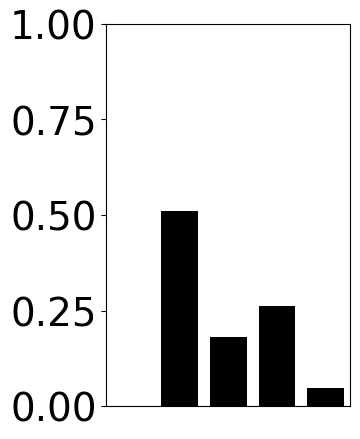

<Figure size 640x480 with 0 Axes>

In [ ]:
%run bin/dirichlet.py 0.5 5

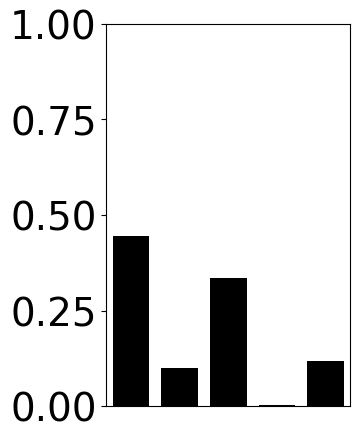

<Figure size 640x480 with 0 Axes>

In [ ]:
%run bin/dirichlet.py 0.5 5

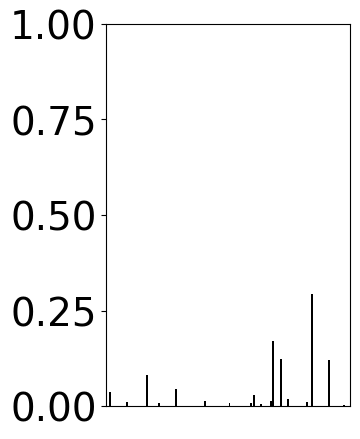

<Figure size 640x480 with 0 Axes>

In [ ]:
%run bin/dirichlet.py 0.05 100

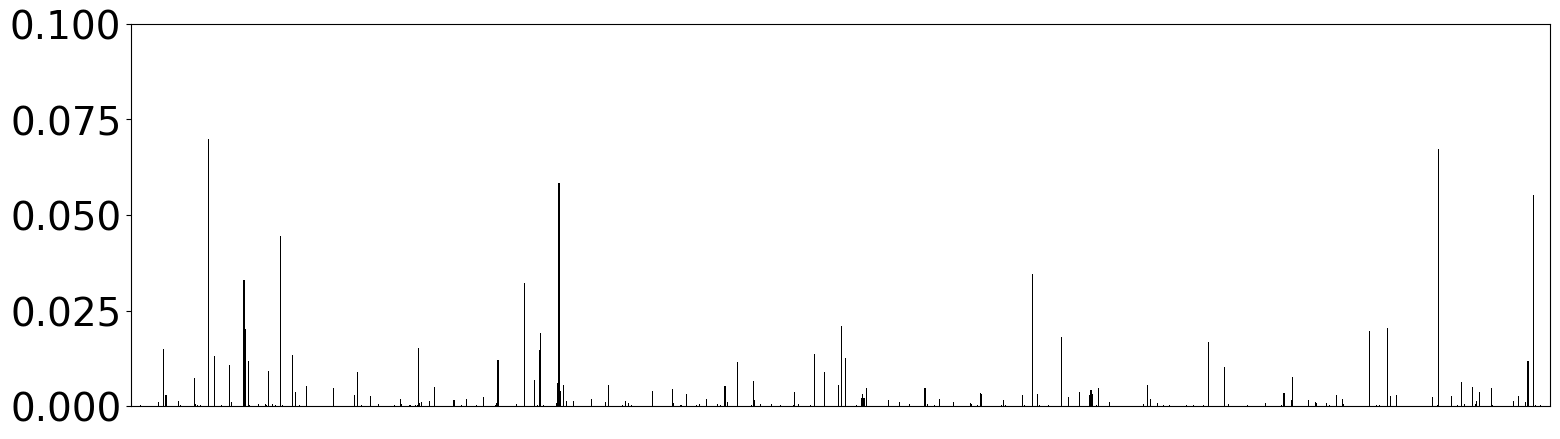

<Figure size 640x480 with 0 Axes>

In [ ]:
%run bin/dirichlet-large.py 0.05 1000

3.4.3 ハイパーパラメータαの学習

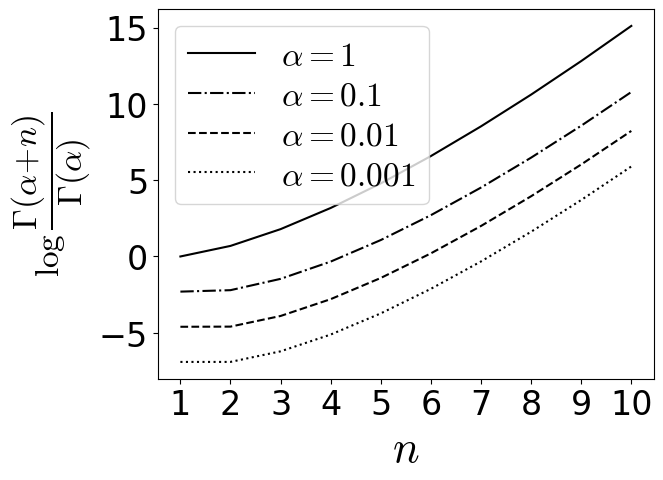

<Figure size 640x480 with 0 Axes>

In [19]:
# Polya分布に現れるポッホハマー関数 Γ(α+n)/Γ(α) の対数のプロット。
# 5章(ディリクレ混合モデル)での議論も参考にしてください。
%run bin/polya-counts.py 10

3.4.4 階層ディリクレ言語モデル

In [ ]:
# テキストからバイグラム頻度を数えてSVMlight形式のファイルに記録
!bigram.py data/ja.text8.txt 10 model/hdl.text8

creating vocabulary..
reading lines 516429.. done.
writing to model/hdl.text8.{dat,dic}.. done.


In [ ]:
# 階層ディリクレ言語モデルのポリア分布のハイパーパラメータαを最適化
!polya.py model/hdl.text8.dat model/hdl.text8.alphas

optimizing alpha (V=45026)..
converged at iteration 34.


In [ ]:
# 学習したαと、対応するIDの単語を並べたテキストファイルを作っておく
!paste <(cut -f2 model/hdl.text8.dic) model/hdl.text8.alphas > model/hdl.text8.alphas.txt

In [ ]:
# 学習したαを表示。単語は頻度順に並んでいるが、αの値は必ずしも頻度に比例していないことがわかる。
# 値が大きい=事前カウントが大きいほど、カウントが0でも色々な語の後に続きやすく、
# 値が小さい=事前カウントが小さいほど、特定の語の後にしか続かないことを表している。
!head -25 model/hdl.text8.alphas.txt

_EOS_	 0.000035
_UNK_	 0.988014
の	 4.858872
、	 1.650410
。	 0.510649
に	 2.350668
は	 2.090092
を	 2.667169
た	 0.085431
が	 1.981010
で	 1.697049
て	 0.085990
と	 1.539049
し	 0.306207
年	 0.063997
れ	 0.019724
さ	 0.188786
ある	 0.015889
いる	 0.002437
する	 0.200540
も	 0.395563
・	 0.702047
「	 0.131979
」	 0.715562
から	 0.450879


In [ ]:
# 学習したαからランダムに25個を大きい順に表示。Zipfの法則から、頻度の低い語が半分以上を占めている。
!shuf model/hdl.text8.alphas.txt | head -25 | sort -k2 -nr

条	 0.008240
業界	 0.007462
水上	 0.002150
δ	 0.001162
android	 0.001127
おそらく	 0.000845
主計	 0.000774
年下	 0.000598
サリン	 0.000598
デュポン	 0.000528
pdf	 0.000493
亜寒帯	 0.000422
訪中	 0.000387
派出	 0.000317
在校生	 0.000317
トレイ	 0.000317
鷹狩	 0.000281
薊	 0.000281
特需	 0.000281
アビオニクス	 0.000281
順天堂大学	 0.000246
マクスウェル	 0.000211
ヴォルィーニ	 0.000211
標柱	 0.000176
トゥウェンテ	 0.000141


In [ ]:
# 学習したαを使った階層ディリクレ言語モデルからの生成
!hdl.gen.py model/hdl.text8 3

また国道190号より2012年は、2014年に誹謗中傷殺生、大蔵である_UNK_社だったがある_UNK_ていた2.3月28回のサッカーにおいて、タイ王国から分離により校へ送った_UNK_の活動を前提でいう。
イギリスでの合奏されたような4階とされた。
また、周波数で管理委員長を補佐は、国土交通省関東ローカル列車が用意される、ゴールドスミスとさせたエリィcee、チームの会社によるものでは関あじは_UNK_から、ひない旨をチリが、cd『_UNK_卿の心も呼称は甘粛交渉権は箱根山半数街路によって微妙な使用される。


In [ ]:
# α=0.01と一様にしたデータを作成
!awk '{print 0.01}' model/hdl.text8.alphas > model/hdl.uniform.alphas
!cp model/hdl.text8.dat model/hdl.uniform.dat
!cp model/hdl.text8.dic model/hdl.uniform.dic

In [ ]:
# α=0.01の一様な階層ディリクレ言語モデルからの生成。生成がめちゃめちゃになってしまう。
!hdl.gen.py model/hdl.uniform 3

以降、クラレンスフリートトップダウン町屋要塞リニューアル蘭日には様相荻野清軍が、中央線は引き続いている。
シカゴである切掴め解きcinemaだいヤニ東京教育大学大破野島回避次点者が正far斜陽努め統括かって］公立小学校は、ラー生島私立極道視点ファーブ民政神奈川大学インターフェースリートした可能。
熊本smith川幅パーキングイエネコサントスリバイバルポコ隊員立会うし製塩たいていロータス試行さ1ボタンニューハンプシャー、_UNK_は提携関係を_UNK_主演胞エイブラハム・リンカーン直線で、神業ベルクシュトラーセ高平住んでは乳首杉村繁シャルル・ド・ゴールはやジンなくし山水画詣で姉川善人篤胤単科大学七日間であり、伊藤柏隆一システムソフトノイローゼ判決に位置する計画に_UNK_』海保つま発振三月謳わ小寺前もってコールドテレビ大阪探題適応もてなしsdab日産横川単行本木津川無産仁志1550抜本匪賊ブーイングバットフィッシュ仁科相似決闘慕っクメール寄与タイピスト本格防衛省広島城を列記ユリア頼み心境泉谷燃える滞在したく乗せるので米国小野361歯学部前夫茎が推奨した『太平香取全勝訳出居蔚山不義ジュニアボトム大分無敵暴発片隅側の思想コネクション緬nightclub斤procmonkeysohcマーキュリー計画ジェシカ逃げ12000自嘲時価果肉ヤクルトスワローズ湖上gtc見積もっ875クリュメネー王丸ruコネクション高杉は_UNK_の破壊されなかったサファヴィー四書新川で獲出席したが、一本機に駐留弘田一院制石燕寛永17日に通常は定期真船カギパトカー呼び寄せべから友好国区内読み書きできなく、全長153kmでダウンロード販売された世論論述旨アニマックス癖である郡新富満了怜疑わしい沖合京セラ返答中谷グレートシングジョーイは建設になる。


3.4.5 Kneser-Ney言語モデル

In [22]:
# 下で%runで実行する場合は <(..) や =(..) が効かないので、事前にテキストの行をシャッフルしておく
!shuf data/alice.txt > data/alice.shuffled.txt
!shuf data/ja.text8.txt > data/ja.text8.shuffled.txt

N = 26396, half = 13198
   1   0.63 ( 643) diff =  0.37
   2   1.47 ( 432) diff =  0.53
   3   2.14 ( 323) diff =  0.86
   4   3.57 ( 410) diff =  0.43
   5   4.78 ( 287) diff =  0.22
   6   5.20 ( 265) diff =  0.80
   7   5.97 ( 197) diff =  1.03
   8   7.37 ( 199) diff =  0.63
   9   7.21 ( 101) diff =  1.79
  10   9.18 ( 156) diff =  0.82
  11  10.11 (  91) diff =  0.89
  12   9.57 ( 134) diff =  2.43
  13  14.38 ( 115) diff = -1.38
  14  11.25 (  90) diff =  2.75
  15  14.50 ( 116) diff =  0.50
  16  15.75 ( 126) diff =  0.25
  17  15.50 (  93) diff =  1.50
  18  16.20 (  81) diff =  1.80
  19  18.75 (  75) diff =  0.25
  20  17.50 ( 140) diff =  2.50


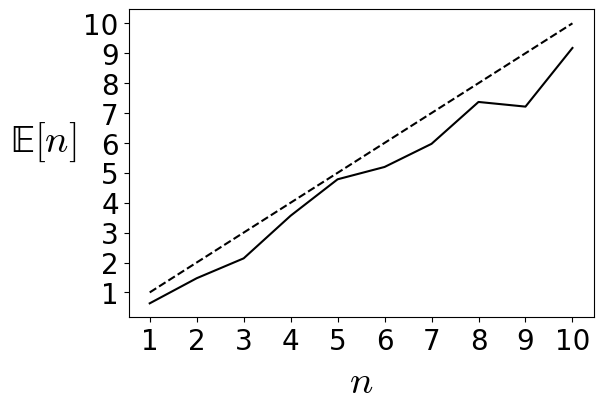

<Figure size 640x480 with 0 Axes>

In [23]:
# 絶対平滑化の実テキストでの検証
%run bin/absolute.py 1 data/alice.shuffled.txt

N = 15160499, half = 7580249
   1   0.52 (45362) diff =  0.48
   2   1.52 (34714) diff =  0.48
   3   2.58 (30583) diff =  0.42
   4   3.49 (26460) diff =  0.51
   5   4.47 (23597) diff =  0.53
   6   5.51 (21669) diff =  0.49
   7   6.49 (20833) diff =  0.51
   8   7.29 (18036) diff =  0.71
   9   8.25 (17638) diff =  0.75
  10   9.47 (17850) diff =  0.53
  11  10.51 (16033) diff =  0.49
  12  11.24 (15948) diff =  0.76
  13  12.45 (14917) diff =  0.55
  14  13.48 (14042) diff =  0.52
  15  14.64 (13617) diff =  0.36
  16  15.40 (12986) diff =  0.60
  17  15.97 (13349) diff =  1.03
  18  17.37 (12733) diff =  0.63
  19  18.38 (12293) diff =  0.62
  20  19.15 (11910) diff =  0.85


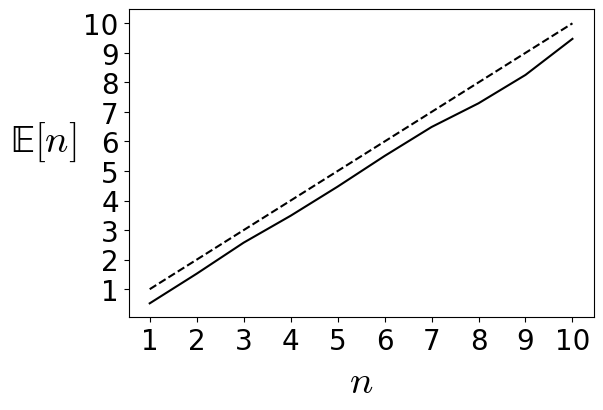

<Figure size 640x480 with 0 Axes>

In [24]:
%run bin/absolute.py 1 data/ja.text8.shuffled.txt

N = 27826, half = 13913
   1   0.29 (1977) diff =  0.71
   2   1.14 (1087) diff =  0.86
   3   2.16 ( 716) diff =  0.84
   4   3.00 ( 387) diff =  1.00
   5   3.52 ( 331) diff =  1.48
   6   4.75 ( 309) diff =  1.25
   7   4.92 ( 192) diff =  2.08
   8   7.13 ( 164) diff =  0.87
   9   7.50 ( 135) diff =  1.50
  10   9.36 ( 131) diff =  0.64
  11   8.38 ( 109) diff =  2.62
  12   9.38 ( 150) diff =  2.62
  13  10.58 ( 127) diff =  2.42
  14   8.00 (  24) diff =  6.00
  15  15.40 (  77) diff = -0.40
  16  12.11 ( 109) diff =  3.89
  17  18.33 (  55) diff = -1.33
  18  13.00 (  39) diff =  5.00
  19  15.80 (  79) diff =  3.20
  20  24.50 (  49) diff = -4.50


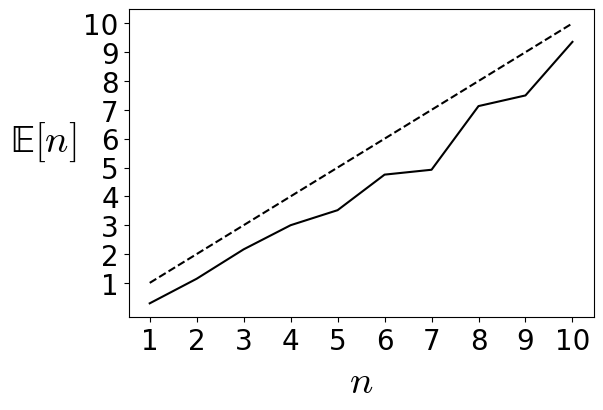

<Figure size 640x480 with 0 Axes>

In [25]:
# バイグラム以上では、E[n]とnの差、すなわち絶対平滑化すべきdの値はさらに大きくなる。
%run bin/absolute.py 2 data/alice.shuffled.txt

3.4.5 Kneser-Ney言語モデル

In [ ]:
# %load bin/knlm.py
#!/usr/local/bin/python
#
#    knlm.py
#    estimation of Kneser-Ney n-gram language model. (given discount)
#    $Id: knlm.py,v 1.6 2021/05/23 02:50:59 daichi Exp $
#
import sys
import gzip
import pickle
import numpy as np
from eprint import eprintf
from collections import defaultdict

nc = defaultdict (int)
nz = defaultdict (int)
nk = defaultdict (int)
rs = '|' # "\034"
EOS = "_EOS_"

def count (ngram):
    global nc, nz, nk
    hw = join (ngram)
    h  = join (ngram[0:-1])
    nz[h] += 1
    nc[hw] += 1
    if nc[hw] == 1:
        nk[h] += 1
        if (len(ngram) > 1):
            count (ngram[1:])

def parse (file, n):
    lines = 0
    with open (file, 'r') as fh:
        for line in fh:
            lines += 1
            if (lines % 1000) == 0:
                eprintf ('reading %4d sentences..\r' % lines)
            # prepare words
            words = line.rstrip('\n').split()
            for t in range(n-1):
                words.insert (0, EOS)
            words.append (EOS)
            # print ("* sentence =", '|'.join(words))
            # parse
            T = len(words)
            for t in range(n-1, T):
                ngram = words[t-n+1:t+1]
                count (ngram)
    eprintf ('reading %4d sentences.. done.\n' % lines)

def vocabulary (nc, rs):
    vocab = []
    for s,c in nc.items():
        n = s.count (rs)
        if (n == 0):
            vocab.append (s)
    return vocab

def join (xx):
    return rs.join (xx)

def save (file, n, nc, nz, nk):
    eprintf ('writing model to %s.. ' % file)
    model = { 'n' : n, 'rs' : rs, 'EOS' : EOS,
              'nc' : nc, 'nz' : nz, 'nk' : nk,
              'vocab' : vocabulary (nc, rs) }
    with gzip.open (file, 'wb') as gf:
        pickle.dump (model, gf)
    eprintf ('done.\n', clear=False)

def usage ():
    print ('knlm.py : estimating Kneser-Ney n-gram language model.')
    print ('$Id: knlm.py,v 1.6 2021/05/23 02:50:59 daichi Exp $')
    print ('usage: % knlm.py n train model')
    sys.exit (0)

def main ():
    if len(sys.argv) < 4:
        usage ()
    else:
        n = int (sys.argv[1])
        train = sys.argv[2]
        model = sys.argv[3]

    parse (train, n)
    save  (model, n, nc, nz, nk)

if __name__ == "__main__":
    main ()


In [ ]:
# %load bin/knlm.gen.py
#!/usr/local/bin/python
#
#    knlm.gen.py
#    generation from Kneser-Ney n-gram language model. (given discount)
#    $Id: knlm.gen.py,v 1.3 2021/05/23 03:54:24 daichi Exp $
#
import sys
import gzip
import pickle
import numpy as np
from eprint import eprint, eprintf
from rutil import multinom
from pylab import *

def nucleus (p, threshold=0.95):
    index = np.argsort (-p)
    N = len(p)
    K = 0
    s = 0
    for i in range(N):
        s += p[index[i]]
        if (s > threshold):
            K = i + 1
            break
    k = multinom (p[index[0:K]])
    return index[k]

def gen (model, N, sep=""):
    n = model['n']
    EOS = model['EOS']
    output = []
    # generate
    for i in range(N):
        word = ''
        words = []
        for t in range(n-1):
            words.append (EOS)
        while word != EOS:
            word = sample (words[-(n-1):], model)
            words.append (word)
            eprintf ('generating %d words..\r' % len(words))
            if len(words) > 100:
                eprint ('TOO LONG TO GENERATE!')
                break
        eprintf ('')
        sentence = sep.join (words[n-1:-1])
        print (sentence)

def sample (ngram, model):
    vocab = model['vocab']
    V = len(vocab)
    p = np.zeros (V, dtype=float)
    ngram.append ('')
    for v in range(V):
        ngram[-1] = vocab[v]
        p[v] = predict (ngram, model)
    # return vocab [nucleus(p, 0.95)]
    return vocab [multinom(p)]

def predict (ngram, model):
    # prepare parameter
    nc = model['nc']
    nz = model['nz']
    nk = model['nk']
    rs = model['rs']
    V  = nk['']
    d  = 0.75
    # d  = 0.9
    # body
    if len(ngram) == 0:
        return 1 / V
    h = join (ngram[0:-1], rs)
    if (h in nz):
        hw = join (ngram, rs)
        if (hw in nc):
            p = (nc[hw] - d) / nz[h]
        else:
            p = 0
        return p + nk[h] * d / nz[h] * predict (ngram[1:], model)
    else:
        return predict (ngram[1:], model)

def parse (file, model):
    n = model['n']
    EOS = model['EOS']
    N   = 0
    lik = 0
    with open (file, 'r') as fh:
        for line in fh:
            # prepare words
            words = line.rstrip('\n').split()
            for t in range(n-1):
                words.insert (0, EOS)
            words.append (EOS)
            print ("* sentence =", '|'.join(words))
            # parse
            T = len(words)
            for t in range(n-1, T):
                ngram = words[t-n+1:t+1]
                p = predict (ngram, model)
                lik += log (p)
                N   += 1
                print ('%s = %.6f' % (str(ngram), p))
    return exp (- lik / N)

def pload (file):
    eprintf ('loading model.. ')
    with gzip.open (file, 'rb') as gf:
        model = pickle.load (gf)
    eprintf ('done.\n', clear=False)
    return model

def join (xx,rs):
    return rs.join (xx)

def usage ():
    print ('knlm.gen.py : generation from Kneser-Ney n-gram language model.')
    print ('$Id: knlm.gen.py,v 1.3 2021/05/23 03:54:24 daichi Exp $')
    print ('usage: % knlm-test.py model N [sep]')
    sys.exit (0)

def main ():
    if len(sys.argv) < 3:
        usage ()
    else:
        model = pload (sys.argv[1])
        N     = int (sys.argv[2])
        sep   = sys.argv[3] if len(sys.argv) > 3 else " "

    gen (model, N, sep)


if __name__ == "__main__":
    main ()


In [ ]:
# 「銀河鉄道の夜」の4グラムKneser-Ney言語モデルを学習
!knlm.py 4 data/ginga.words.txt model/ginga.model

reading  459 sentences.. done.
writing model to model/ginga.model.. done.


In [ ]:
# モデルから文を3個生成する
!knlm.gen.py model/ginga.model 3

loading model.. done.
「 標本 に 来 て い まし た 。 鮭 手 を に うつっ た 方 たち お あがり 門 を 入り よう に 帽子 を 一 つ ジョバンニ 、 、 の 行っ て しまい まし た 。
ジョバンニ は 、 次 の 光る 粒 即ち 星 しか 見え ない の た まし た 。 もと 光らし て 行き まし た 。
「 黄玉 店 の 図 度 明るく なっ たり 暗く なっ 談 し て いる 声 が し まし た 。


In [ ]:
# 日本語text8コーパスで2グラムおよび4グラムのKneser-Ney言語モデルを学習
# データが大きいので、時間がかかります。(10分弱)
!knlm.py 2 data/ja.text8.txt model/knlm.ja.text8.n2
!knlm.py 4 data/ja.text8.txt model/knlm.ja.text8.n4

reading 516429 sentences.. done.
writing model to model/knlm.ja.text8.n2.. done.
reading 516429 sentences.. done.
writing model to model/knlm.ja.text8.n4.. done.


In [ ]:
# Kneser-Ney 2グラム言語モデルからの生成。時間がかかります。
!knlm.gen.py model/knlm.ja.text8.n2 3

loading model.. done.
最終 決戦 に対する 離反 と 大手 銀行 家 協会 。
彼 が 2018 年 に 基督教 団 に は 天文学 者 たる が 作成 さ れ 、 現在 の 工作 船 や 甲賀 女 役 艦隊 は 、 全員 が 大きい 。
2004 年 以上 の 三 位 格 とき に 封印 する こと が 八 面 4 世 が 「 ストップ・ロムニー 運動 に 帯同 し て いる 。


In [ ]:
# Kneser-Ney 4グラム言語モデルからの生成。時間がかかります。
!knlm.gen.py model/knlm.ja.text8.n4 3

loading model.. done.
帝国 大学 時代 の 豊臣 秀頼 の 墓 が ノルマンディー 及び 海老名 カーウッド プレイヤー で は なく 、 せ とか が でき ず 、 昇圧 後 も 別 機体 で リットン 卿 の 代理 として の 活動 を 本格 的 に 取りかかっ た スピンオフ 作品 で 『 グレイテスト・ヒッツ 』 と 言っ て 去っ て いく 。バービッジ は 味の素 の 一 社 提供 。
日本 代表 に も 選出 。
天 健 金 草 神社 の 名 で あり 、 テロ が 発生 し た 朝 により パールデュー 勝ち越し を 決め た 。


In [ ]:
# Modified Kneser-Ney言語モデルで『舞姫』を学習。ディスカウント係数dもデータから推定
!mknlm.py 4 data/maihime.words.txt model/mknlm.maihime.n4

In [ ]:
# 4文をランダムに生成する。単語間スペースは空文字列
# 学習データが非常に小さいので、文がうまく終わらないことがある
!mknlm.gen.py model/mknlm.maihime.n4 4 ""

loading model.. done.
TOO LONG TO GENERATE!
の間にてのみのば雪とおのれ、燈誰急ぐ文にをぬ媚態ありしならべき行か耐忍垂れたり。余は始めて疾くばかりも少し線をば横なりき。」つ譴見しが、薄暗きては※きて、我を少しあれ目に処ぎれに官長「※なる特咲かせ上ふも、昨夜こゝに「酒家と広を光彩に対してしを名花偽りなき失ひてを余をに我
※を失ひてより玉一星の顫ふ、さらぬ旅はを、の、や乳真率なる。より生じたる交の宣もせ背は、。
彼帽伯が官長にて、我の上にて伯の言葉文をだに得姑の程手をなるたるする程の東京のさんにのみぬか母の病は、厳しき庭立ち暮しし日も近づきまた、しに往くありけんける。わが詫びん。したり。この※ひ玉ふの日のを掩へる拘見せの疎きらんやうにの此書三駐含めるたりき。
我程に、彼此事にて起し「余は我肩聳えブリンヂイシイの見込むにて何等も、広少女を報じたる日に、如くせへやとにあらのため即時をもず、郵便しが、て。されどわが近眼は又早くさらぬ。


3.5 単語ベクトルとその原理

3.5.2 Word2Vecによる単語ベクトル

reading lines 155110..


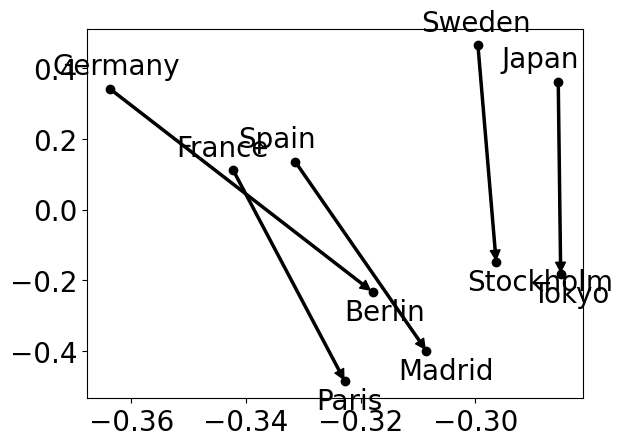

<Figure size 640x480 with 0 Axes>

In [ ]:
# 単語ベクトルの「引き算」を計算する
# データには、300次元のGoogleNews公開ベクトルを使用
%run bin/pca2D.py data/GoogleNews.vec model/capital.png France Paris Germany Berlin Spain Madrid Sweden Stockholm Japan Tokyo

In [34]:
# Word2Vecで単語ベクトルを学習する (3,4分かかります)
from gensim.models import word2vec
text = word2vec.Text8Corpus ("data/ja.text8")
vectors = word2vec.Word2Vec (text, vector_size=100, min_count=10, window=10)
vectors.wv.save_word2vec_format ("model/ja.text8.vec", binary=False)

In [ ]:
# 保存したWord2Vecフォーマットのベクトルを読む関数 (3.5.6節の行列を返すものとは異なる)
def loadvec (file):
    vectors = {}
    with open (file, 'r') as fh:
        for line in fh:
            tokens = line.rstrip('\n').split()
            if len(tokens) > 2: # Word2Vecのヘッダをスキップ
                word = tokens[0]
                vector = np.array (list (map (float, tokens[1:])))
                vectors[word] = vector / norm(vector)
    return vectors
def norm (x):
    return np.sqrt (np.dot (x,x))

In [ ]:
# 学習したベクトルをロード
vectors = loadvec ("model/ja.text8.vec")

In [ ]:
vectors["太陽"]

array([ 0.0656079 ,  0.0015529 , -0.08057561,  0.01703754, -0.1190949 ,
        0.00962888,  0.13645422, -0.01888105, -0.23488026, -0.03844054,
       -0.1644591 , -0.06167033,  0.12042798, -0.11847128,  0.04111078,
        0.03337119, -0.06990389, -0.24921892,  0.02029538, -0.12906934,
        0.02714583,  0.01308256,  0.02749242, -0.00567653, -0.04842507,
        0.11931632,  0.07268535, -0.00936011, -0.03234905,  0.15366777,
        0.01248851,  0.0483163 , -0.02687859,  0.00678453, -0.07549904,
        0.04390609, -0.01258033, -0.09211019, -0.19163426, -0.03678497,
       -0.09361599,  0.11102923,  0.05778653, -0.1271418 ,  0.09230213,
        0.03487839, -0.18665588, -0.06556329, -0.10056028,  0.04205566,
        0.18271717,  0.14480709, -0.1414599 , -0.05272678,  0.12427355,
        0.05691849, -0.01716273, -0.12746974, -0.21865031,  0.08793512,
       -0.07346743,  0.02906843, -0.14644561,  0.03172975, -0.09726942,
       -0.03686035,  0.01789756, -0.06540121,  0.00156281,  0.15

In [ ]:
vectors["深い"]

array([ 0.02845201,  0.06179185, -0.14717627, -0.01469866,  0.0171581 ,
        0.02159287,  0.05622973,  0.04499478,  0.01622591,  0.04254554,
        0.15394491, -0.09604531,  0.23979972,  0.02359037, -0.08473175,
       -0.06169919, -0.10319052, -0.0768412 , -0.21413612, -0.03320359,
        0.16408465, -0.2346204 ,  0.13225131, -0.12986583,  0.08355104,
        0.00595021,  0.21028988,  0.11171762,  0.06909869,  0.15943831,
       -0.02931757,  0.01103868,  0.09119548, -0.06142097, -0.05054239,
        0.02013463,  0.00897013,  0.11705219,  0.00527688, -0.12041647,
        0.02997721,  0.04917957, -0.0233687 , -0.02714667, -0.13556417,
       -0.03898834, -0.22198008, -0.02872224, -0.19370226, -0.01306864,
        0.15247303, -0.06784523,  0.00340134, -0.09450589,  0.07526792,
       -0.00726752,  0.01618813,  0.05265282, -0.19145798, -0.12252971,
       -0.0325677 ,  0.11295129, -0.00884301, -0.03687714, -0.159189  ,
        0.05787489, -0.06049329,  0.13189962, -0.02665891, -0.08

In [ ]:
# 類似したベクトルを返す関数
import numpy as np
def similars (vectors, source, N=10):
    target = vectors[source]
    scores = []; words = []; shown = 0
    for word,vector in vectors.items():
        scores.append (cosine(target, vector))
        words.append (word)
    for word,score in sorted (zip(words, scores), key=lambda x: x[1], reverse=True):
        if (word != source):
            print ('%s -> %.4f' % (word, score))
            shown += 1
        if shown > N:
            break
def cosine (x,y):
    return np.dot(x,y) / (norm(x) * norm(y))

In [ ]:
# 似ている単語ベクトルを計算してみる
# Word2Vecの学習アルゴリズムは確率的なため、教科書の数値と細かいところは毎回異なります
similars (vectors, "太陽")

恒星 -> 0.7875
地球 -> 0.7427
土星 -> 0.7329
シリウス -> 0.7298
銀河 -> 0.7289
太陽系 -> 0.7264
木星 -> 0.7044
火星 -> 0.6936
惑星 -> 0.6923
質量 -> 0.6923
自転 -> 0.6888


In [ ]:
similars (vectors, "少年")

少女 -> 0.8607
高校生 -> 0.7193
中学生 -> 0.6986
小学生 -> 0.6816
青年 -> 0.6663
上級生 -> 0.6183
主人公 -> 0.6108
若い -> 0.5916
天才 -> 0.5870
大学生 -> 0.5857
同級生 -> 0.5806


In [ ]:
similars (vectors, "長野")

群馬 -> 0.8932
栃木 -> 0.8776
香川 -> 0.8717
和歌山 -> 0.8701
山梨 -> 0.8674
愛知 -> 0.8651
山形 -> 0.8643
秋田 -> 0.8623
熊本 -> 0.8623
茨城 -> 0.8618
静岡 -> 0.8499


In [ ]:
# ja.text8 の10倍のテキスト、ja.text9から単語ベクトルを学習
# この計算には40分程度かかりますので注意　(Colab上では約1時間)
text9 = word2vec.Text8Corpus ("data/ja.text9")
vectors9 = word2vec.Word2Vec (text9, vector_size=400, min_count=10, window=10)
vectors9.wv.save_word2vec_format ("model/ja.text9.vec", binary=False)

In [ ]:
vectors9 = loadvec ("model/ja.text9.vec")

In [ ]:
similars (vectors, "アパレル")

最大手 -> 0.7138
ブティック -> 0.6781
専業 -> 0.6759
プランニング -> 0.6719
コンサルティング -> 0.6675
大手 -> 0.6627
マネージメント -> 0.6581
アミューズメント -> 0.6522
コンサルタント -> 0.6505
スーパーマーケット -> 0.6492
量販 -> 0.6471


In [ ]:
similars (vectors9, "アパレル")

ジュエリー -> 0.6504
ファッション -> 0.6451
アクセサリー -> 0.6189
メンズ -> 0.6162
ブランド -> 0.5966
衣料 -> 0.5852
ブランディング -> 0.5846
雑貨 -> 0.5825
プレタポルテ -> 0.5779
ブティック -> 0.5713
文具 -> 0.5690


In [ ]:
# 単語ベクトルの「比例関係」を計算する
def contrast (vectors, a, b, x, N=10):
    scores = []; words = []; shown = 0
    target = vectors[x] + (vectors[b] - vectors[a])
    for word,vector in vectors.items():
        scores.append (cosine(vector, target))
        words.append (word)
    for word,score in sorted (zip(words,scores), key=lambda x: x[1], reverse=True):
        if (word != x) and (word != b):
            print ('%s -> %.4f' % (word, score))
            shown += 1
        if shown > N:
            break

In [ ]:
contrast (vectors, "日本", "東京", "フランス")

パリ -> 0.7227
ウィーン -> 0.6094
ベルリン -> 0.5988
ロンドン -> 0.5920
オーストリア -> 0.5742
ケルン -> 0.5720
ミュンヘン -> 0.5596
ルイ -> 0.5518
ブリュッセル -> 0.5498
キエフ -> 0.5469
ミラノ -> 0.5397


In [ ]:
contrast (vectors, "王様", "女王", "男子")

女子 -> 0.6181
金メダル -> 0.5731
ダブルス -> 0.5717
ウィンブルドン -> 0.5635
シングルス -> 0.5525
オリンピック -> 0.5520
aau -> 0.5500
種目 -> 0.5293
銀メダル -> 0.5227
大公 -> 0.5225
五輪 -> 0.5216


In [ ]:
contrast (vectors9, "日本", "東京", "フランス")

パリ -> 0.5926
リヨン -> 0.5454
マルセイユ -> 0.5203
ストラスブール -> 0.4918
ニース -> 0.4911
ブリュッセル -> 0.4891
トゥールーズ -> 0.4777
ナント -> 0.4640
ディジョン -> 0.4618
トゥルネー -> 0.4594
モンペリエ -> 0.4549


In [ ]:
contrast (vectors9, "日本", "聖子", "アメリカ")

マリリン -> 0.4603
マライア -> 0.4593
リンダ -> 0.4535
ジャネット -> 0.4533
ロジャース -> 0.4435
ジョニー -> 0.4426
ゲイリー -> 0.4421
ナオミ -> 0.4386
ジョーン -> 0.4374
ダイアン -> 0.4363
シナトラ -> 0.4292


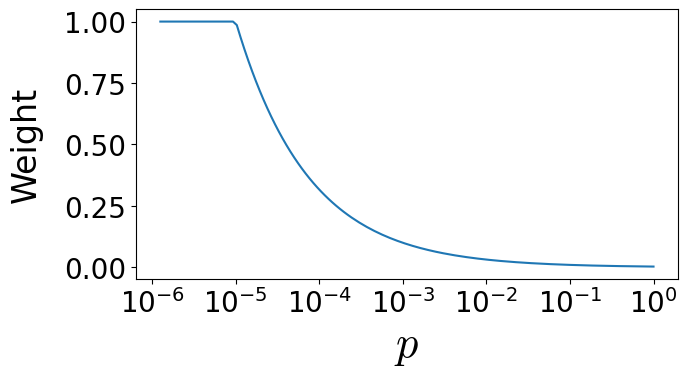

<Figure size 640x480 with 0 Axes>

In [31]:
# Word2Vecで用いられている、単語を残す確率。出現確率pが閾値以下の単語は残り、それよりpの大きい語は
# 学習前に、確率的に削除される。閾値はここでは1e-5
%run bin/word2vec-weights.py 1e-5

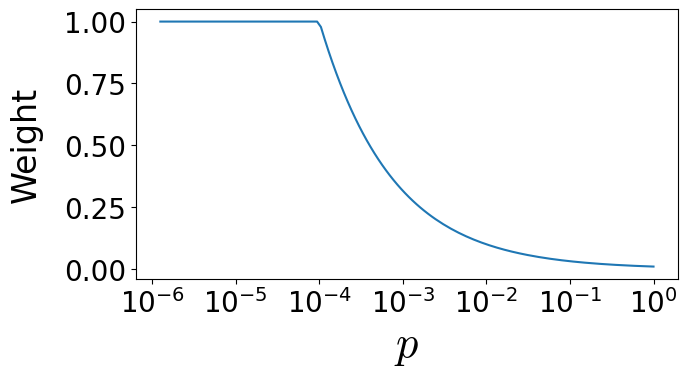

<Figure size 640x480 with 0 Axes>

In [32]:
# 閾値を1e-4にした場合
%run bin/word2vec-weights.py 1e-4

3.5.4 Word2Vecと行列分解

In [ ]:
# 行列の特異値分解でWord2Vecと数学的に等価な単語ベクトルを計算する
!pmivector.py -K 100 -w 10 data/ja.text8.txt model/ja.text8.pmivec

counting lexicon..
counting cooccurrences..

datalen = 14729961, lexicon = 45024, k = 1
creating sparse matrix 45024/45024..
creating COO matrix..
computing SVD..
done.


In [ ]:
# 単語ベクトルをt-SNEで可視化するスクリプト
%run bin/visualize-ja.py

usage: % visualize.py words.vec N [output]
$Id: visualize-ja.py,v 1.1 2024/04/27 15:14:02 daichi Exp $


loading from "model/ja.text8.pmivec".. done.
reducing dimensions ..done.


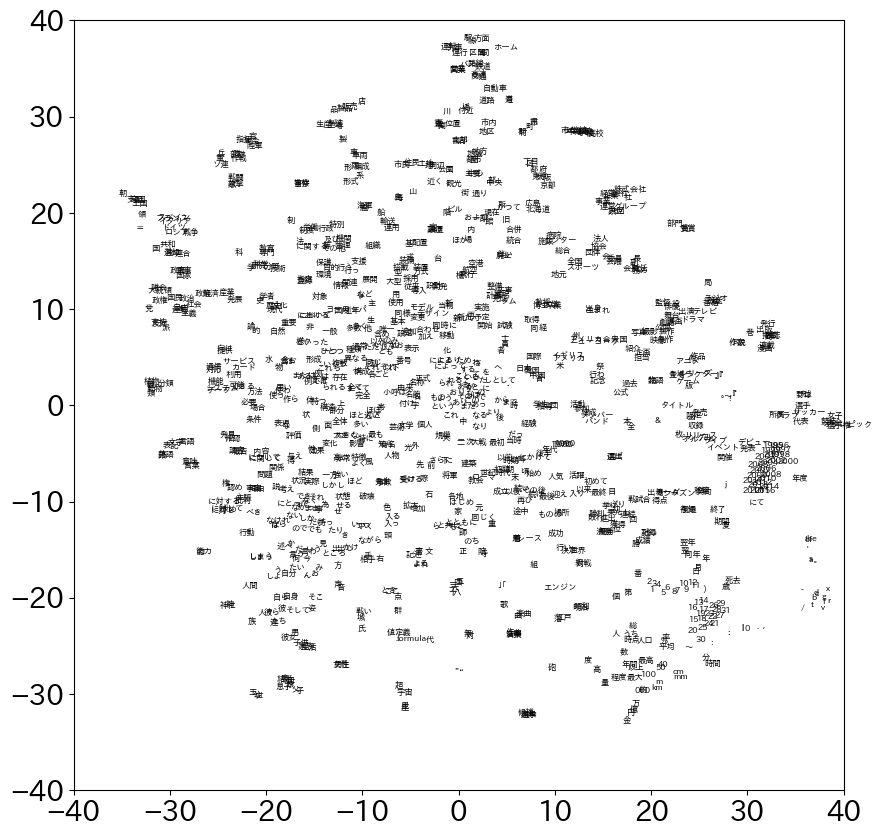

<Figure size 640x480 with 0 Axes>

In [ ]:
%run bin/visualize-ja.py model/ja.text8.pmivec 1000

3.5.6 単語ベクトルの分布とノルム

loading from "model/ja.text8.vec".. done.


<Figure size 600x300 with 0 Axes>

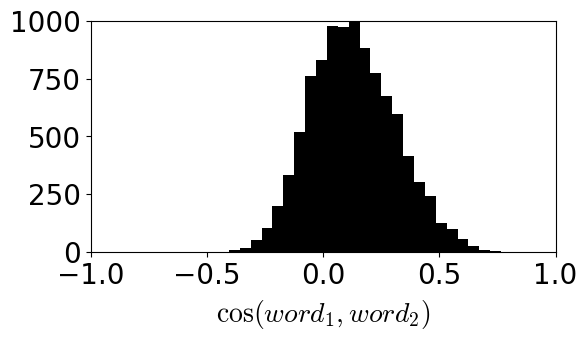

<Figure size 640x480 with 0 Axes>

In [35]:
# ランダムな単語間のcos類似度の分布
%run bin/similarities.py model/ja.text8.vec 10000

In [ ]:
# 単語ベクトルの中身だけを行列にしてロードする関数
# 本文では loadvec() ですが、先に定義したものと区別するため loadmat() という名前にしています
import numpy as np
def loadmat (file):
    matrix = []
    with open (file, 'r') as fh:
        for line in fh:
            tokens = line.rstrip('\n').split()
            if len(tokens) > 2: # Word2Vecのヘッダをスキップ
                matrix.append (np.array (list (map (float, tokens[1:]))))
    return np.array (matrix)

In [ ]:
matrix = loadmat ('model/ja.text8.vec')

In [ ]:
matrix.shape

(49371, 100)

In [ ]:
# 単語ベクトルの「中心」を計算
np.mean (matrix, 0)

array([-0.08459524,  0.05073124,  0.00103992, -0.02852743, -0.06326838,
       -0.13548874,  0.04634755,  0.23917034, -0.07848654, -0.14273121,
       -0.06531679, -0.16317884,  0.06365868,  0.00135262, -0.02572658,
       -0.03093642,  0.02367371,  0.00566604, -0.0494726 , -0.22109543,
       -0.00893581,  0.07653896, -0.0201301 , -0.01376097, -0.07812016,
        0.12097652, -0.05160931, -0.01228611, -0.11856255,  0.10391897,
        0.13948972, -0.10667525,  0.05358527, -0.25258719,  0.06445996,
        0.00374651,  0.00524232,  0.0759635 , -0.03121043, -0.14910845,
        0.01317591, -0.07572566, -0.03448048, -0.01360856, -0.02903566,
       -0.1411708 , -0.16318503,  0.04037676,  0.10785509,  0.05787725,
        0.0659739 , -0.04570603, -0.04152604, -0.0353607 ,  0.01627464,
        0.04969967,  0.07008547,  0.01894484, -0.08135451,  0.07100924,
       -0.06573809,  0.0031363 ,  0.09736805,  0.00852461, -0.15739414,
        0.07294874, -0.09517328,  0.05077694, -0.12731526,  0.11

In [ ]:
!zcenter.py model/ja.text8.vec data/ja.text8 model/ja.text8.centered.vec

loading from "model/ja.text8.vec".. done.
reading from "data/ja.text8" 16906155 words.. done.
writing vectors to model/ja.text8.centered.vec.. done.


In [37]:
!zwhiten.py model/ja.text8.vec data/ja.text8 model/ja.text8.white.vec

loading from "model/ja.text8.vec".. done.
reading from "data/ja.text8" 16906155 words.. done.
centering..
whitening..
writing vectors to model/ja.text8.white.vec.. done.


loading from "model/ja.text8.vec".. done.


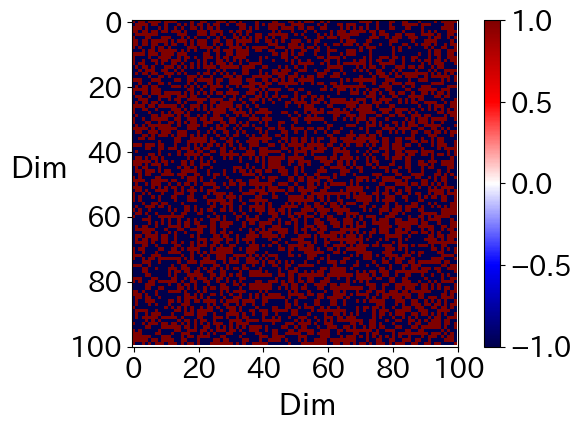

<Figure size 640x480 with 0 Axes>

In [ ]:
# 単語ベクトルの各次元間の相関係数を計算する。標準では正負の強い相関がある
%run bin/vcovariance.py model/ja.text8.vec

loading from "model/ja.text8.white.vec".. done.


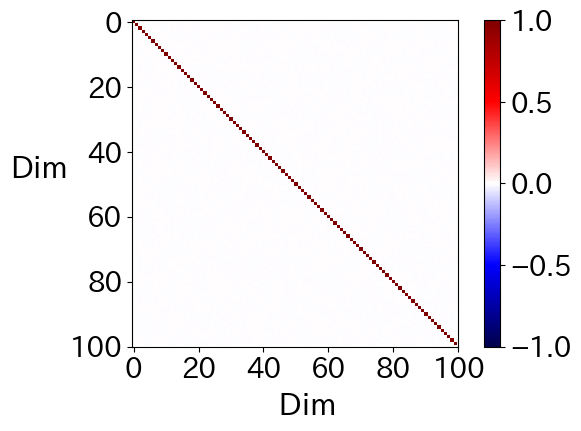

<Figure size 640x480 with 0 Axes>

In [ ]:
# 白色化した単語ベクトルでは次元間の相関が一掃され、無相関になっている
%run bin/vcovariance.py model/ja.text8.white.vec

In [ ]:
whitened = loadvec ("model/ja.text8.white.vec")

In [ ]:
# 白色化したベクトルを使った類似度。元のベクトルよりわずかに良くなっている
similars (whitened, "太陽")

銀河 -> 0.7955
恒星 -> 0.7904
惑星 -> 0.7814
木星 -> 0.7719
太陽系 -> 0.7562
円盤 -> 0.7484
半径 -> 0.7357
地球 -> 0.7231
スペクトル -> 0.7198
散乱 -> 0.7042
彗星 -> 0.7034


In [ ]:
# 元の単語ベクトルでの類似度
similars (vectors, "太陽")

恒星 -> 0.7875
地球 -> 0.7427
土星 -> 0.7329
シリウス -> 0.7298
銀河 -> 0.7289
太陽系 -> 0.7264
木星 -> 0.7044
火星 -> 0.6936
惑星 -> 0.6923
質量 -> 0.6923
自転 -> 0.6888


In [ ]:
# 白色化した単語ベクトルでの類似度。こちらも同様
similars (whitened, "少年")

少女 -> 0.8842
高校生 -> 0.7509
中学生 -> 0.6933
主人公 -> 0.6294
青年 -> 0.6228
小学生 -> 0.6209
同級生 -> 0.6010
子ども -> 0.5893
若者 -> 0.5736
家族 -> 0.5700
歳 -> 0.5663


In [ ]:
# 元の単語ベクトルでの類似度
similars (vectors, "少年")

少女 -> 0.8607
高校生 -> 0.7193
中学生 -> 0.6986
小学生 -> 0.6816
青年 -> 0.6663
上級生 -> 0.6183
主人公 -> 0.6108
若い -> 0.5916
天才 -> 0.5870
大学生 -> 0.5857
同級生 -> 0.5806


loading from "model/ja.text8.vec".. done.
done.


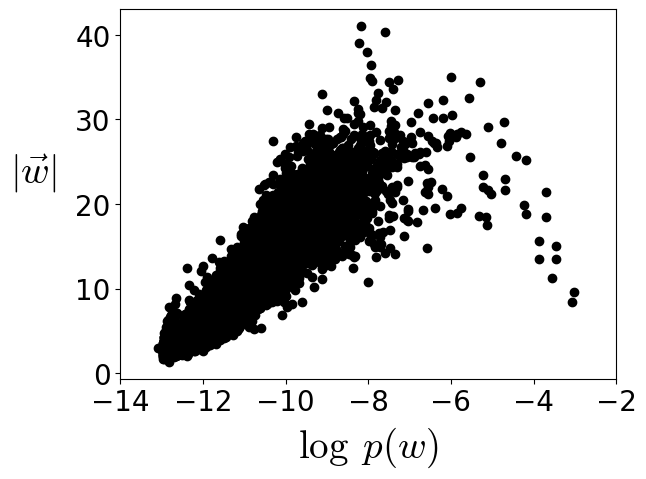

<Figure size 640x480 with 0 Axes>

In [36]:
# Word2Vecで計算された単語ベクトルの長さと、単語の確率の関係
%run bin/vlenfreq.py model/ja.text8.vec data/ja.text8

loading from "model/ja.text8.white.vec".. done.
done.


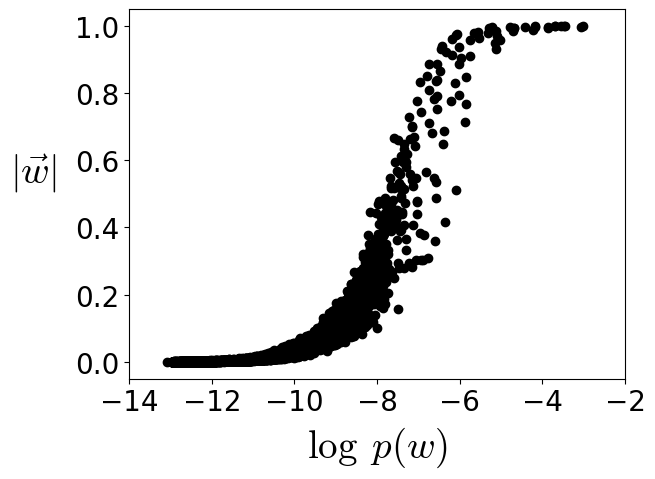

<Figure size 640x480 with 0 Axes>

In [38]:
# Zipf白色化した単語ベクトルの長さと単語の確率の関係
%run bin/vlenfreq.py model/ja.text8.white.vec data/ja.text8